In [176]:
import pandas as pd
import numpy as np

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#for plotting football pitch
from matplotlib.patches import Arc

#for modelling
from sklearn.preprocessing import normalize 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from scipy.spatial.distance import cdist

In [177]:
#setting up the screen to view the data fully
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Loading the Data

In [178]:
# Importing the file and reading the data
df_1 = pd.read_csv('/Users/devanshchawla/Downloads/DataAnalystTask.csv',encoding = "ISO-8859-1",parse_dates=True)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (27,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [179]:
# Keeping a copy of the original data set
df = df_1.copy()


## Exploratory Data analysis

In [180]:
# Going throught the data set of everton player
df_everton = df[df['Team']=='Everton']

In [181]:
# Checking out the different players in the everton team for comparing later
df_everton = df_everton[df_everton['detailed_position']=='Central Defender']
df_everton['Player Surname'].unique()


array(['Jagielka', 'Keane', 'Holgate', 'Zouma', 'Mina'], dtype=object)

In [182]:
#list(df.columns)

In [183]:
#df.info(verbose=True)

In [184]:
#df.describe()

In [185]:
# Checking the null values
#df.isnull().sum()

#### Basic Data Cleaning and handling Missing values

In [186]:
#dropping columns to clean the data
column = [ 'Competition Id','Competition Name','Game Date',
           'Game_period_1_start','Game_period_2_start','Season Id','Season Name',
           'event_id','type_id','TypeName','TypeDescription']

df = df.drop(column,axis=1)

In [187]:
# since these values are less than 1% , chose to drop them
df = df.dropna(subset=['detailed_position'],axis=0)

# Filling all the NaN in the forename column with an empty string and creating a nre column with name
df['Player Forename']= df['Player Forename'].fillna("")
df['name']= df['Player Forename']+" "+ df['Player Surname']
df = df.drop(['Player Forename','Player Surname'], axis=1) 

In [188]:
# since id is unique, setting up it as the index
df=df.set_index('id')

In [189]:
#scaling the data as per the pitch dimensions
def pitch_scale_x(x):
    return x*1.3

def pitch_scale_y(y):
    return y*0.9

In [190]:
# Scaling the pitch
df['x'] = df['x'].apply(pitch_scale_x)
df['y'] = df['y'].apply(pitch_scale_x)
df['Pass End X'] = df['Pass End X'].apply(pitch_scale_x)
df['Pass End Y'] = df['Pass End Y'].apply(pitch_scale_x)

In [191]:
#finding the matches played by each player to normalize the data as per match and then multiplying
#90 min to make it per 90

#creating dictionary of unique players
players = list(df['name'].unique())
matches = {}
for i in players:
    df_player = df[df['name']==i]
    matches[i]= df_player['Game_id'].nunique()
   

In [192]:
# Matches played by each player and mapping it to the player name, setting the index
df_matches = pd.DataFrame(matches, index=[0])
df_matches = df_matches.T
df_matches = df_matches.reset_index()
df_matches.columns = ['name','matches']
#df_matches 


#### Keeping all the functions at one place


In [193]:
# for passing length
def pass_len(x):
    if x <40:
        return 'short'
    else:
        return 'Long'
    
    
# for passing outcome   
def pass_outcome(x):
    if x == 0:
        return 'Fail'
    else:
        return 'success'
    
# for passing direction    
def pass_dir(x):
    if (x <45)|(x>315):
        return 'Forward pass' 
    elif (x>=90) & (x<270):
        return 'backward pass'
    else:
        return 'side ways'
    

# convertind radian into degree    
def degree(x):
    return x*57.2958

#### Manipulating for passing 

In [194]:
# Categorzing if its a long ball or short pass, limit kept is 40m here
df['pass type'] = df['Length'].apply(pass_len)

# Categorzing If the pass was successfull or not
df['outcome'] = df['outcome'].apply(pass_outcome)

# Converting the angle to increase readability
df.loc[:,'Angle'] =df.loc[:,'Angle'].apply(degree)

# Categorizing the direction of the pass; forward, backward, sideways
df.loc[:,'Pass direction']= df.loc[:,'Angle'].apply(pass_dir)

## Inspecting the player to be analysed 



In [195]:
df_keane = df[df['name']=='Michael Keane']
df_chris = df[df['name']=='Andreas Christensen']
df_kurt = df[df['name']=='Kurt Zouma']
df_gomez = df[df['name']=='Joseph Gomez']
df_laporte = df[df['name']=='Aymeric Laporte']
df_lindelof = df[df['name']=='Victor Lindelöf']
df_sanchez = df[df['name']=='Davinson Sánchez']
df_ake = df[df['name']=='Nathan Aké']
df_mina = df[df['name']=='Yerry Mina']
df_holgate = df[df['name']=='Mason Holgate']
df_Jagielka = df[df['name']=='Phil Jagielka']
df_koch = df[df['name']=='Robin Koch']
df_light = df[df['name']=='Matthijs de Ligt']
 
 

### Data Manipulation
The idea of creating dataframe is to breakdown the problem in small parts and look closely what is going on.
 1. players  
 2. events
 3. descriptors
 4. Possession
 5. Passing Pattern
 6. Match Data

In [196]:
# player
cols_pl      = ['Game_id','Team','name','Position Id','detailed_position']

# event descriptor
cols_desc    = ['event_id','type_id', 'TypeName','TypeDescription',]

# possession
cols_pos     = ['Game_id','Team','Possession_id','MatchName','Flank Pass','Subbed on?','Subbed off?','Throw in',
                'Own Goal','Goal Kick','Possession Sequence', 'Possession Amount','Time','Time of Possession',
                'Seconds Between','End of Possession','Possession End with Shot','Lost Possession']

#passing plotting
cols_plot    = ['Game_id','Team','name','x','y','Pass End X','Pass End Y','Angle','Length','outcome',
               'pass type','Pass direction']

#shots 
cols_shot     = ['Game_id','Team','name','Key Pass','2nd Assist','Assist','Goal','Shot','Fast Break Shot']

#defence
cols_def     = [ 'Game_id','name', 'Defensive Duel', 'Attacking Duel', 'Interception', 'Successful Tackle',
                 'Dispossessed/Tackled', 'Re`d','Yellow']

#player profiling
cols_profile = ['name','Matchday','Game_id','Pass Receiver Position_id','GK Shot Faced','Gk kick from hands','Keeper Throw',
                'detailed_position','Mins Played' ,'Defensive Duel','Interception','Successful Tackle','Aerial Duel',
                'Blocked Cross','Blocked A Shot','Tackle Attempt','Ball Recovery']  





#### Creating Dataframe for each of the section

In [197]:

#creating pass data for description
describe = df.filter(cols_desc,axis=1)

# Creating player profile
player = df.filter(cols_pl, axis=1)

#creating possesion profile
possession = df.filter(cols_pos,axis=1)

#creating pass data for plotting
pass_plot = df.filter(cols_plot,axis=1)
 
#creating pass data for shots
events = df.filter(cols_shot,axis=1)

#creating pass data for defence
defence = df.filter(cols_def,axis=1)

#creating player profile
profile = df.filter(cols_profile,axis=1)

#### Creating Dataframe for pass plotting

In [198]:
#pass plotting for multiple players
df_keane_plot = df_keane.filter(pass_plot,axis=1).dropna()
df_kurt_plot = df_kurt.filter(pass_plot,axis=1).dropna()
df_chris_plot = df_chris.filter(pass_plot,axis=1).dropna()
df_gomez_plot = df_gomez.filter(pass_plot,axis=1).dropna()
df_laporte_plot = df_laporte.filter(pass_plot,axis=1).dropna()
df_lindelof_plot = df_lindelof.filter(pass_plot,axis=1).dropna()
df_sanchez_plot = df_sanchez.filter(pass_plot,axis=1).dropna()
df_ake_plot = df_ake.filter(pass_plot,axis=1).dropna() 
df_mina_plot = df_mina.filter(pass_plot,axis=1).dropna() 
df_holgate_plot = df_holgate.filter(pass_plot,axis=1).dropna() 
df_Jagielka_plot = df_Jagielka.filter(pass_plot,axis=1).dropna() 
df_koch_plot = df_koch.filter(pass_plot,axis=1).dropna()  
df_light_plot = df_light.filter(pass_plot,axis=1).dropna()  
 
 



#### Creating Dataframe for profiling of each player

In [199]:
df_keane_profile = df_keane.filter(profile,axis=1) 
df_kurt_profile = df_kurt.filter(profile,axis=1) 
df_chris_profile = df_chris.filter(profile,axis=1) 
df_gomez_profile = df_gomez.filter(profile,axis=1) 
df_laporte_profile = df_laporte.filter(profile,axis=1) 
df_lindelof_profile = df_lindelof.filter(profile,axis=1) 
df_sanchez_profile = df_sanchez.filter(profile,axis=1) 
df_ake_profile = df_ake.filter(profile,axis=1).dropna() 
df_mina_profile = df_mina.filter(profile,axis=1).dropna() 
df_holgate_profile = df_holgate.filter(profile,axis=1)
df_Jagielka_profile = df_Jagielka.filter(profile,axis=1) 
df_koch_profile = df_koch.filter(profile,axis=1)
df_light_profile = df_light.filter(profile,axis=1) 
 

In [200]:
#creating xl file to generate visualisation in Tableau
keane = pd.concat([df_keane_plot],axis=0)
keane.to_excel('/Users/devanshchawla/Desktop/Data_sciene resume/keane.xlsx',index=False)

#### Creating Profiles for all the players across the season
Each attributes is alloted a score based on the wieghted mean to compete the score. This is done to give the relative importance to each attribute 
1. Defensive Duel	 -  10.0
2. Interception	     -  9.3
3. Successful Tackle -  10.0
4. Aerial Duel	     -  8.7
5. Blocked Cross	 -  6.0
6. Blocked A Shot	 -  7.7
7. Tackle Attempt	 -  7.3
8. Ball Recovered	 -  7.7

In [201]:
#Creating the profile with the attributes important to defenders
df_profile = df.filter(cols_profile,axis=1)

In [202]:
# choosing only Central Defender
df_profile_cd = df_profile[df_profile['detailed_position']=='Central Defender']

In [203]:
# grouping the data on player name to make each row of 1 single player
cols = ['Matchday','Game_id','Pass Receiver Position_id','GK Shot Faced','Gk kick from hands','Keeper Throw','Mins Played']
cols2 = ['Matchday','Game_id','Pass Receiver Position_id','GK Shot Faced','Gk kick from hands','Keeper Throw']

# dropping certain columns which are less-relevant to a Central defender
df_profile = df_profile_cd.groupby(['name'],as_index=False).sum().drop(cols,axis=1)

# Creating a average minute column to map to each player
df_minutes = df_profile_cd.groupby(['name'],as_index=False).mean().drop(cols2,axis=1)

# filtering the minutes
df_minutes = df_minutes.filter(['Mins Played'],axis=1)

#Concatening the two dataframe to make 1 dataframe
df_profile = pd.concat([df_profile,df_minutes],axis=1)

df_profile = df_profile.merge(df_matches, left_on='name', right_on='name')
df_profile['score'] =df_profile['Defensive Duel']*10.0 + df_profile['Interception']*9.3 + df_profile['Successful Tackle']*10+df_profile['Aerial Duel']*8.7 + df_profile['Blocked Cross']*6.0 + df_profile['Blocked A Shot']*7.7+ df_profile['Tackle Attempt']*7.3+ df_profile['Ball Recovery']*7.7     

df_profile

,name,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery,Mins Played,matches,score
0,Arthur Henrique,13,3,5,4,0,4,6,0,80.623288,2,317.3
1,Artur Jorge,120,23,18,60,3,15,22,0,93.340038,20,2410.0
2,Bremer,15,5,1,11,1,0,3,0,96.000000,1,330.1
3,Bruno Viana,194,49,23,115,10,24,31,0,94.840405,32,4097.3
4,Carlos Ponck,176,49,30,98,4,20,40,0,92.803198,31,3838.3
5,Diogo Leite,27,9,2,22,0,1,3,0,96.821168,3,594.7
6,Ferro,112,21,24,56,3,5,32,0,94.242911,13,2332.6
7,Gabriel,99,18,11,55,4,8,16,0,94.914474,11,1948.3
8,Gonçalo Cardoso,107,16,8,63,5,14,12,0,93.173859,15,2072.3
9,Igor Julio,181,59,27,72,1,13,43,0,93.855856,23,3675.1


In [204]:
#since not every player has same number of match we need to map this with per match stats per 90 minutes
df_profile['Tackle Attempt']=((df_profile['Tackle Attempt']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Defensive Duel']=((df_profile['Defensive Duel']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Interception']=((df_profile['Interception']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Successful Tackle']=((df_profile['Successful Tackle']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Aerial Duel']=((df_profile['Aerial Duel']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Blocked Cross']=((df_profile['Blocked Cross']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Blocked A Shot']=((df_profile['Blocked A Shot']/df_profile['Mins Played'])*90)/df_profile['matches']
df_profile['Ball Recovery']=((df_profile['Ball Recovery']/df_profile['Mins Played'])*90)/df_profile['matches']
 

In [205]:
#creating xl file to generate visualisation in Tableau
keane = pd.concat([df_profile],axis=0)
keane.to_excel('/Users/devanshchawla/Desktop/Data_sciene resume/cluster.xlsx',index=False)

# Data Modelling

### 1. Scoring Model
Each attributes is alloted a score based on the wieghted mean to compete the score. This is done to give the relative importance to each attribute 


In [206]:
# Calculating score for each player
df_profile['score'] =df_profile['Defensive Duel']*10.0 + df_profile['Interception']*9.3 + df_profile['Successful Tackle']*10+df_profile['Aerial Duel']*8.7 + df_profile['Blocked Cross']*6.0 + df_profile['Blocked A Shot']*7.7+ df_profile['Tackle Attempt']*7.3+ df_profile['Ball Recovery']*7.7     



In [207]:
df_profile

,name,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery,Mins Played,matches,score
0,Arthur Henrique,7.255968,1.674454,2.790757,2.232606,0.000000,2.232606,3.348908,0.000000,80.623288,2,177.101436
1,Artur Jorge,5.785299,1.108849,0.867795,2.892649,0.144632,0.723162,1.060638,0.000000,93.340038,20,116.188082
2,Bremer,14.062500,4.687500,0.937500,10.312500,0.937500,0.000000,2.812500,0.000000,96.000000,1,309.468750
3,Bruno Viana,5.753086,1.453099,0.682067,3.410334,0.296551,0.711722,0.919308,0.000000,94.840405,32,121.505768
4,Carlos Ponck,5.505928,1.532900,0.938510,3.065801,0.125135,0.625674,1.251347,0.000000,92.803198,31,120.076160
5,Diogo Leite,8.365939,2.788646,0.619699,6.816691,0.000000,0.309850,0.929549,0.000000,96.821168,3,184.267556
6,Ferro,8.227511,1.542658,1.763038,4.113756,0.220380,0.367300,2.350718,0.000000,94.242911,13,171.352615
7,Gabriel,8.533999,1.551636,0.948222,4.741110,0.344808,0.689616,1.379232,0.000000,94.914474,11,167.947371
8,Gonçalo Cardoso,6.890345,1.030332,0.515166,4.056932,0.321979,0.901540,0.772749,0.000000,93.173859,15,133.447300
9,Igor Julio,7.546262,2.459831,1.125685,3.001828,0.041692,0.541997,1.792758,0.000000,93.855856,23,153.222470


### 2. Cosine Similarity
- The model being used here is Cosine similarity which measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. So each player is considered is a vector here and similarity is term reported in terms of cosine value

In [208]:
#creating for micheal keeane
df_test_1 = df_profile[ df_profile['name']=='Michael Keane'] 
#removing the player from the main list to avoid self mapping
df_def_1 = df_profile[ df_profile['name']!='Michael Keane'] 
df_def_1= df_def_1.reset_index(drop=True)
#display(df_test_1)
#display(df_def_1)



In [209]:
# cosine similarity of the defenders and the Keane
u = cosine_similarity((df_test_1.drop(['name','Mins Played','matches'],axis=1)),(df_def_1.drop(['name','Mins Played','matches'],axis=1)))
u1 = list(u.shape)
u = u.reshape(u1[1],1)
df_cos = pd.DataFrame(u)



In [210]:
#concating the player's name and the cosine similarity value
df_cos_name1 = pd.concat([df_def_1['name'],df_cos], axis=1)

#renaming the column
df_cos_name1.columns = ['name','cos']

#taking out the row for the maximum cosine value
df_cos_name1=df_cos_name1.sort_values(by='cos',ascending=False)
df_cos_name1


,name,cos
148,Matthijs de Ligt,0.999986
212,Yerry Mina,0.999978
176,Phil Jagielka,0.999975
145,Mason Holgate,0.999973
184,Robin Koch,0.999969
108,John Stones,0.999968
21,Messias,0.999963
86,Germán Conti,0.999962
46,Björn Engels,0.999955
73,Duje Caleta-Car,0.999954


In [211]:
# Eucleidean distance, we have normalize the data for better results as distance depends on the magnitude in the 
# dimension
e = euclidean_distances(normalize(df_test_1.drop(['name','Mins Played','matches'],axis=1)),normalize(df_def_1.drop(['name','Mins Played','matches'],axis=1)))
u1 = list(e.shape)
e = e.reshape(u1[1],1)
df_eu = pd.DataFrame(e)

In [212]:
df_cos_name3 = pd.concat([df_def_1['name'],df_eu], axis=1)

#renaming the column
df_cos_name3.columns = ['name','dist']

#taking out the row for the maximum cosine value
df_cos_name3=df_cos_name3.sort_values(by='dist',ascending=True)
df_cos_name3

,name,dist
148,Matthijs de Ligt,0.005333
212,Yerry Mina,0.006639
176,Phil Jagielka,0.007073
145,Mason Holgate,0.007347
184,Robin Koch,0.007900
108,John Stones,0.007959
21,Messias,0.008603
86,Germán Conti,0.008693
46,Björn Engels,0.009482
73,Duje Caleta-Car,0.009588


### 3. Kmeans Clustering


In [213]:
df_profile  

,name,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery,Mins Played,matches,score
0,Arthur Henrique,7.255968,1.674454,2.790757,2.232606,0.000000,2.232606,3.348908,0.000000,80.623288,2,177.101436
1,Artur Jorge,5.785299,1.108849,0.867795,2.892649,0.144632,0.723162,1.060638,0.000000,93.340038,20,116.188082
2,Bremer,14.062500,4.687500,0.937500,10.312500,0.937500,0.000000,2.812500,0.000000,96.000000,1,309.468750
3,Bruno Viana,5.753086,1.453099,0.682067,3.410334,0.296551,0.711722,0.919308,0.000000,94.840405,32,121.505768
4,Carlos Ponck,5.505928,1.532900,0.938510,3.065801,0.125135,0.625674,1.251347,0.000000,92.803198,31,120.076160
5,Diogo Leite,8.365939,2.788646,0.619699,6.816691,0.000000,0.309850,0.929549,0.000000,96.821168,3,184.267556
6,Ferro,8.227511,1.542658,1.763038,4.113756,0.220380,0.367300,2.350718,0.000000,94.242911,13,171.352615
7,Gabriel,8.533999,1.551636,0.948222,4.741110,0.344808,0.689616,1.379232,0.000000,94.914474,11,167.947371
8,Gonçalo Cardoso,6.890345,1.030332,0.515166,4.056932,0.321979,0.901540,0.772749,0.000000,93.173859,15,133.447300
9,Igor Julio,7.546262,2.459831,1.125685,3.001828,0.041692,0.541997,1.792758,0.000000,93.855856,23,153.222470


In [214]:
X = df_profile.drop(['name','matches','score','Mins Played'],axis=1).values

In [215]:
#scaler object creation
scaler = MinMaxScaler()

# transforming the data as the distance depends on the magnitude 
X_scaled = scaler.fit_transform(X)



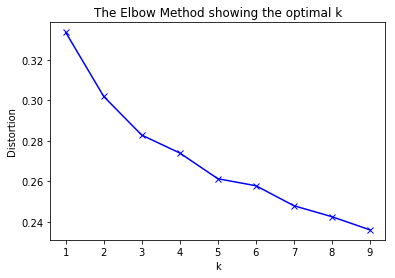

In [216]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled)
    kmeanModel.fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [217]:
# applying kmeans here creating 4 cluster
# 4 is chosen as the elbow point here

# Creating the object
kmeans = KMeans(n_clusters=3)

#fitting on the data
kmeans.fit(X_scaled)

#predincting on the training set
y_kmeans = kmeans.predict(X_scaled)

Text(0.5, 1.0, 'Kmeans(before PCA)')

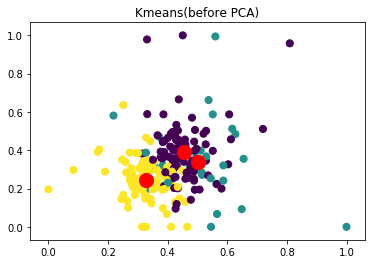

In [218]:
# Plotting the scatter for scaled data. this is done before PCA
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')

# creating centres to plot
centers = kmeans.cluster_centers_

#plotting the centre
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200);

# adding title
plt.title('Kmeans(before PCA)')
 

In [219]:
# here we are implementing PCA to reduce dimensionallity for better visualization and understanding
from sklearn.decomposition import PCA

# 2 dimension creating for X-Y plot
pca = PCA(n_components=2).fit(X)

# transforming the X using PCA
pca_2d = pca.transform(X) 

In [220]:
# Creating the object
kmeans = KMeans(n_clusters=3)

#fitting on the data
kmeans.fit(pca_2d)

#predincting on the reduced dimension X-Y
y_kmeans = kmeans.predict(pca_2d)

Text(0.5, 1.0, 'Kmeans(After PCA)')

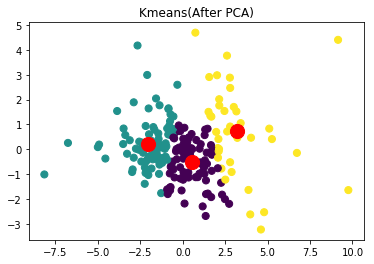

In [221]:
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200);
            
plt.title('Kmeans(After PCA)')
                

# Data Analysis

## Analysis - Part 1 : Passing and depth Heatmap

In [222]:
#Draw pitch function
def draw_pitch():
    #Create figure
    fig=plt.figure()
    fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")

    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")

    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    centreSpot = plt.Circle((65,45),0.8,color="black")
    leftPenSpot = plt.Circle((11,45),0.8,color="black")
    rightPenSpot = plt.Circle((119,45),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    
    #Tidy Axes
    plt.axis('off')


#### Joe Gomez

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


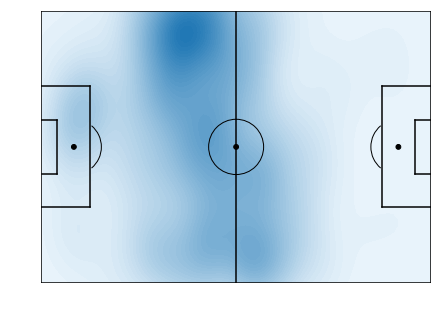

In [223]:
# Successful passing heatmap

draw_pitch()
#sucess
gomez_succes = df_gomez_plot[df_gomez_plot['outcome']=='success']
sns.kdeplot(gomez_succes['Pass End X'],gomez_succes['Pass End Y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)

#Display Pitch
plt.show()

#### Aymeric Laporte

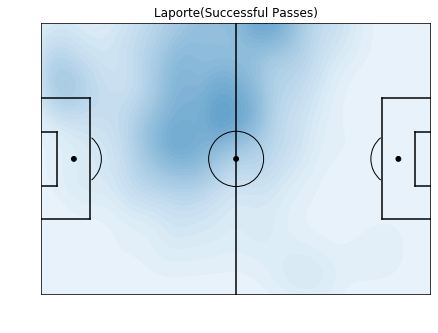

In [224]:
# Successful passing heatmap

draw_pitch()

#sucess
laporte_succes = df_laporte_plot[df_laporte_plot['outcome']=='success']
ax = sns.kdeplot(laporte_succes['Pass End X'],laporte_succes['Pass End Y'], shade=True,n_levels=50)

plt.title('Laporte(Successful Passes)')
fig = ax.get_figure()
fig.savefig('laporte.png')


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

#### Kurt Gumoz

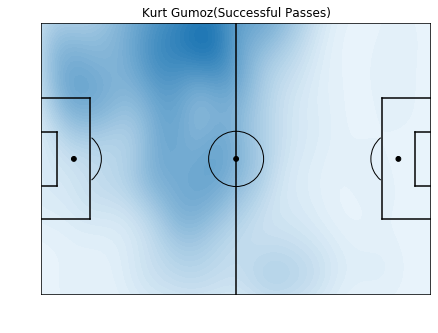

In [225]:
# Successful passing heatmap

draw_pitch()

kurt_succes = df_kurt_plot[df_kurt_plot['outcome']=='success']
ax=sns.kdeplot(kurt_succes['Pass End X'],kurt_succes['Pass End Y'], shade=True,n_levels=50)

plt.title('Kurt Gumoz(Successful Passes)')
fig = ax.get_figure()
fig.savefig('Kurt.png')


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

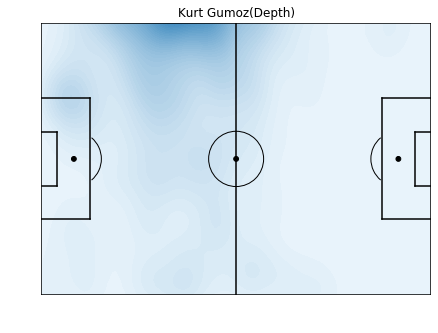

In [226]:
#depth

draw_pitch()
 
    
ax=sns.kdeplot(df_kurt_plot['x'],df_kurt_plot['y'], shade=True,n_levels=50)

plt.title('Kurt Gumoz(Depth)')
fig = ax.get_figure()
fig.savefig('Kurt_d.png')


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

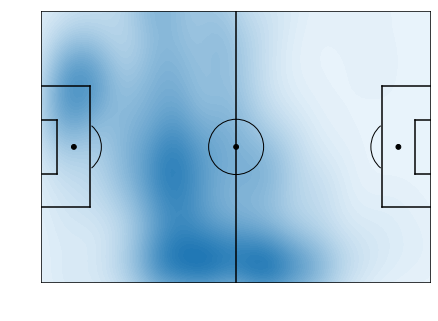

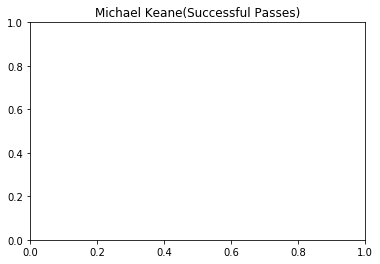

In [227]:
# Successful passing heatmap

draw_pitch()


#sucess
keane_succes = df_keane_plot[df_keane_plot['outcome']=='success']
ax = sns.kdeplot(keane_succes['Pass End X'],keane_succes['Pass End Y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

#adding title
plt.title('Michael Keane(Successful Passes)')

fig = ax.get_figure()
fig.savefig('keane1.png')

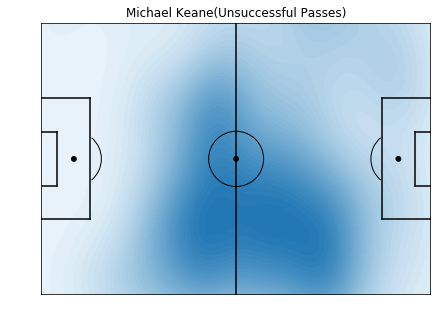

In [228]:
# Unsuccessful passing heatmap

draw_pitch()

#adding title
plt.title('Michael Keane(Unsuccessful Passes)')

fig = ax.get_figure()
fig.savefig('keane_un.png')
#sucess
keane_un_succes = df_keane_plot[df_keane_plot['outcome']=='Fail']
ax = sns.kdeplot(keane_un_succes['Pass End X'],keane_un_succes['Pass End Y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()


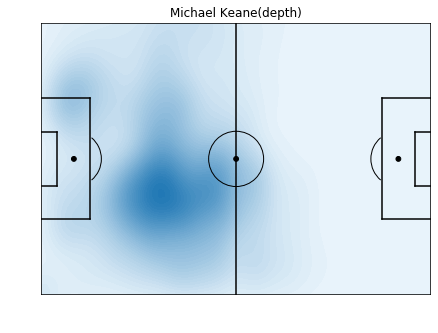

In [229]:
#depth

draw_pitch()

#adding title
plt.title('Michael Keane(depth)')

fig = ax.get_figure()
fig.savefig('keane_location.png')
#sucess
ax = sns.kdeplot(df_keane_plot['x'],df_keane_plot['y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()


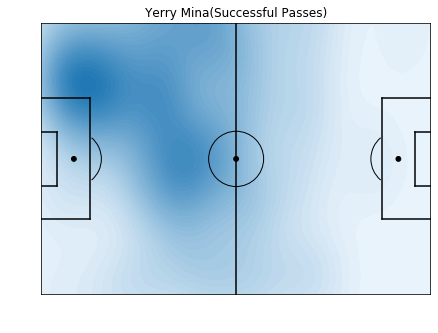

In [230]:
# Successful passing heatmap

draw_pitch()

#sucess
mina_success = df_mina_plot[df_mina_plot['outcome']=='success']
sns.kdeplot(mina_success['Pass End X'],mina_success['Pass End Y'], shade=True,n_levels=50)

plt.title('Yerry Mina(Successful Passes)')
fig = ax.get_figure()
fig.savefig('Yerry.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

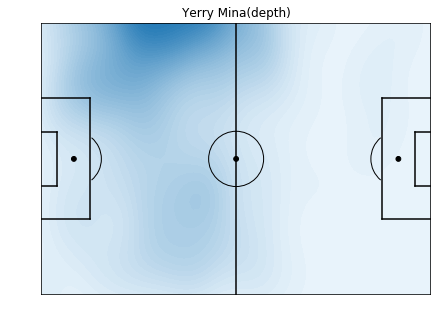

In [231]:
#depth

draw_pitch()

#sucess
sns.kdeplot(df_mina_plot['x'],df_mina_plot['y'], shade=True,n_levels=50)

plt.title('Yerry Mina(depth)')
fig = ax.get_figure()
fig.savefig('Yerry_d.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

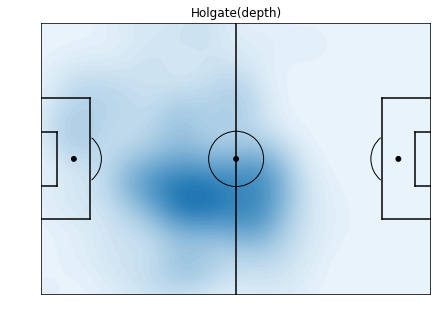

In [232]:
#depth

draw_pitch()

#sucess
sns.kdeplot(df_holgate_plot['x'],df_holgate_plot['y'], shade=True,n_levels=50)

plt.title('Holgate(depth)')
fig = ax.get_figure()
fig.savefig('Holgate_1_d.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

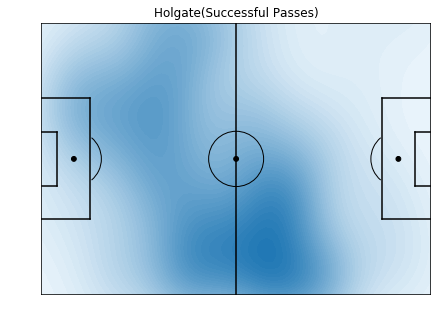

In [233]:
# Successful passing heatmap

draw_pitch()

#sucess
holgate_sucess = df_holgate_plot[df_holgate_plot['outcome']=='success']
sns.kdeplot(holgate_sucess['Pass End X'],holgate_sucess['Pass End Y'], shade=True,n_levels=50)

plt.title('Holgate(Successful Passes)')
fig = ax.get_figure()
fig.savefig('hool.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

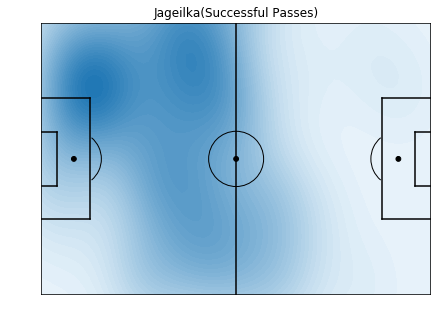

In [234]:
# Successful passing heatmap

draw_pitch()

#sucess
Jagielka_success= df_Jagielka_plot[df_Jagielka_plot['outcome']=='success']
sns.kdeplot(Jagielka_success['Pass End X'],Jagielka_success['Pass End Y'], shade=True,n_levels=50)

plt.title('Jageilka(Successful Passes)')
fig = ax.get_figure()
fig.savefig('jag.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

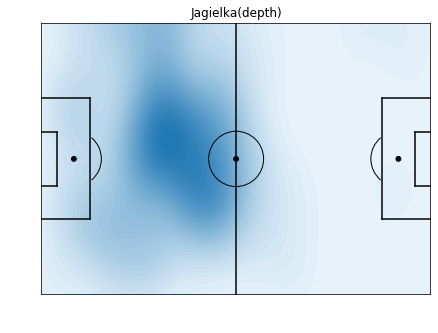

In [235]:
# depth

draw_pitch()

#sucess
sns.kdeplot(df_Jagielka_plot['x'],df_Jagielka_plot['y'], shade=True,n_levels=50)

plt.title('Jagielka(depth)')
fig = ax.get_figure()
fig.savefig('Jagielka_d.png')

plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()
 

#### Analyszing  5  players of everton

players = 'Phil Jagielka', 'Michael Keane', 'Mason Holgate', 'Kurt Zouma', 'Yerry Mina'


In [236]:
df_def = pd.concat([df_kurt_plot,df_keane_plot,df_mina_plot,df_holgate_plot,df_Jagielka_plot,df_koch_plot,df_light_plot],axis=0)
#df_def

In [237]:
# creating the number of passes in detail for each one

#initialising for summation later
kurt_sw = 0
kurt_fd = 0
kurt_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Kurt Zouma':
        if row['Pass direction']=='side ways':
            kurt_sw = kurt_sw + 1
        elif row['Pass direction']=='Forward pass':
            kurt_fd = kurt_fd + 1
        if row['Pass direction']=='backward pass':
            kurt_bk = kurt_bk + 1

#creating a list
l1 = ['Kurt Zouma',kurt_sw,kurt_fd,kurt_bk]



holgate_sw = 0
holgate_fd = 0
holgate_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Mason Holgate':
        if row['Pass direction']=='side ways':
            holgate_sw = holgate_sw + 1
        elif row['Pass direction']=='Forward pass':
            holgate_fd = holgate_fd + 1
        if row['Pass direction']=='backward pass':
            holgate_bk = holgate_bk + 1

l2 = ['Mason Holgate',holgate_sw,holgate_fd,holgate_bk]
        
Jagielka_sw = 0
Jagielka_fd = 0
Jagielka_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Phil Jagielka':
        if row['Pass direction']=='side ways':
            Jagielka_sw = Jagielka_sw + 1
        elif row['Pass direction']=='Forward pass':
            Jagielka_fd = Jagielka_fd + 1
        if row['Pass direction']=='backward pass':
            Jagielka_bk = Jagielka_bk + 1
            
l3 = ['Phil Jagielka',Jagielka_sw,Jagielka_fd,Jagielka_bk]

            
keane_sw = 0
keane_fd = 0
keane_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Michael Keane':
        if row['Pass direction']=='side ways':
            keane_sw = keane_sw + 1
        elif row['Pass direction']=='Forward pass':
            keane_fd = keane_fd + 1
        if row['Pass direction']=='backward pass':
            keane_bk = keane_bk + 1

l4 = ['Michael Keane',keane_sw,keane_fd,keane_bk]

koch_sw = 0
koch_fd = 0
koch_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Robin Koch':
        if row['Pass direction']=='side ways':
            koch_sw = koch_sw + 1
        elif row['Pass direction']=='Forward pass':
            koch_fd = koch_fd + 1
        if row['Pass direction']=='backward pass':
            koch_bk = koch_bk + 1

l5 = ['Robin Koch',koch_sw,koch_fd,koch_bk]
            
light_sw = 0
light_fd = 0
light_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Matthijs de Ligt':
        if row['Pass direction']=='side ways':
            light_sw = light_sw + 1
        elif row['Pass direction']=='Forward pass':
            light_fd = light_fd + 1
        if row['Pass direction']=='backward pass':
            light_bk = light_bk + 1

l6 = ['Matthijs de Ligt',light_sw,light_fd,light_bk]


mina_sw = 0
mina_fd = 0
mina_bk = 0

for i, row in df_def.iterrows():
    if row['name']=='Yerry Mina':
        if row['Pass direction']=='side ways':
            mina_sw = kurt_sw + 1
        elif row['Pass direction']=='Forward pass':
            mina_fd = kurt_fd + 1
        if row['Pass direction']=='backward pass':
            mina_bk = kurt_bk + 1

l7 = ['Yerry Mina',mina_sw,mina_fd,mina_bk]
            

In [238]:
# creating a dataframe form the lists that are created above
df_pas_ration = pd.DataFrame([l1,l2,l3,l4,l5,l6,l7])

# column naming
df_pas_ration.columns =[['name', 'sidways','forward','backward']]
df_pas_ration

,name,sidways,forward,backward
0,Kurt Zouma,558,605,431
1,Mason Holgate,89,125,47
2,Phil Jagielka,66,74,55
3,Michael Keane,592,809,401
4,Robin Koch,129,122,88
5,Matthijs de Ligt,946,793,649
6,Yerry Mina,559,606,432


In [239]:
#check file name

In [240]:
# Creating the excel for visualization
df_pas_ration.to_excel('/Users/devanshchawla/Desktop/Data_sciene resume/pass_ratio1.xlsx',index=False)

## Analysis - Part 2  : Attributes Analysis


1. Interceptions versus vs blocks
2. Tackles vs blocks
3. Interceptions versus vs recoveries
4. Aerial Duels


In [241]:
# for 4 players of everton
players =['Phil Jagielka', 'Michael Keane', 'Mason Holgate', 'Kurt Zouma', 'Yerry Mina']

In [242]:
# everton defender
df_edf = df_profile[(df_profile['name']=='Phil Jagielka')|(df_profile['name']=='Michael Keane')|(df_profile['name']=='Mason Holgate')|(df_profile['name']=='Kurt Zouma')|(df_profile['name']=='Yerry Mina')]

In [243]:
df_edf

,name,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery,Mins Played,matches,score
130,Kurt Zouma,5.411250,1.555329,0.583249,4.795599,0.194416,0.421235,0.972081,0.0,95.777467,29,127.637465
145,Mason Holgate,8.299574,0.691631,0.691631,6.455224,0.000000,0.461087,0.922175,0.0,97.595376,4,162.786914
155,Michael Keane,9.307380,1.313311,0.685206,8.993328,0.085651,0.628105,1.142010,0.0,95.525365,33,204.068597
177,Phil Jagielka,7.409000,0.463063,0.926125,6.482875,0.231531,0.000000,1.389188,0.0,97.179104,4,155.589003
213,Yerry Mina,7.467694,0.581898,0.678881,6.109932,0.387932,0.484915,1.163796,0.0,92.799729,10,154.590968


In [244]:
#creating xl file to generate visualisation in Tableau
df_edf.to_excel('/Users/devanshchawla/Desktop/Data_sciene resume/def_edf.xlsx',index=False)

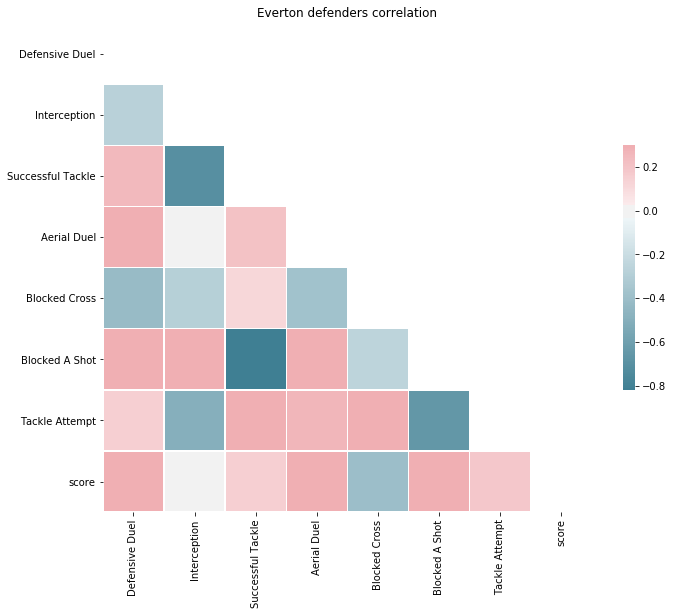

In [245]:
# correlation matrix for the attrubites
corr = df_edf.drop(['name','Mins Played','matches','Ball Recovery'],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Everton defenders correlation')
fig = ax.get_figure()
fig.savefig('Ev_def.png')

#### Relation between Intercpetions and Tackles


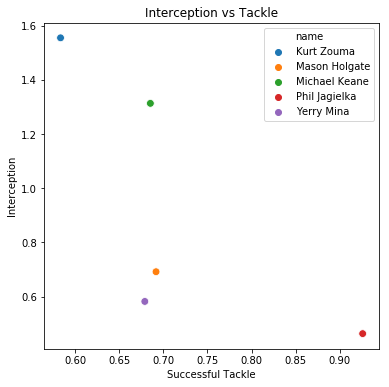

In [246]:
plt.figure(figsize=(6, 6))
ax = sns.scatterplot(df_edf['Successful Tackle'], df_edf['Interception'],s=60, hue =df_edf['name'], legend='full')

# adding title
plt.title('Interception vs Tackle')
fig = ax.get_figure()

# Saving the figure
fig.savefig('Int_vs_tackle.png')
            
                

In [247]:
df_edf.loc[:,'blocks'] = df_edf.loc[:,'Blocked Cross']+df_edf.loc[:,'Blocked A Shot']

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Relation between Intercpetions and Tackles


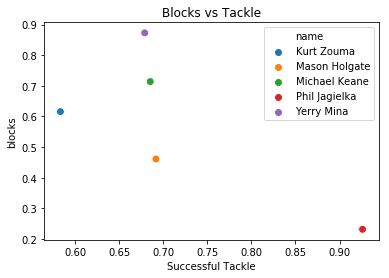

In [248]:
ax = sns.scatterplot(df_edf['Successful Tackle'], df_edf['blocks'],s=60, hue =df_edf['name'],legend='brief')

# adding title
plt.title('Blocks vs Tackle')

fig = ax.get_figure()

# Saving the figure
fig.savefig('blocks_vs_tackle.png')
            

#### Relation between Intercpetions and blocks

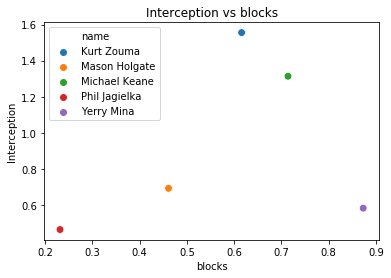

In [249]:
ax = sns.scatterplot(df_edf['blocks'], df_edf['Interception'],s=60, hue =df_edf['name'], legend='brief')
# adding title
plt.title('Interception vs blocks')
fig = ax.get_figure()

#saving the figure
fig.savefig('Int_vs_blocks.png')
            

#### Bar plot for inteceptions of 5 players

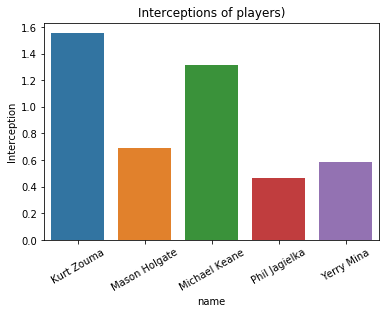

In [250]:
ax = sns.barplot(x ='name',y="Interception", data=df_edf)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

# add title
plt.title('Interceptions of players)')
fig = ax.get_figure()

#save figure
fig.savefig('Interceptio.png')
            

#### Bar plot for Aerial of 5 players

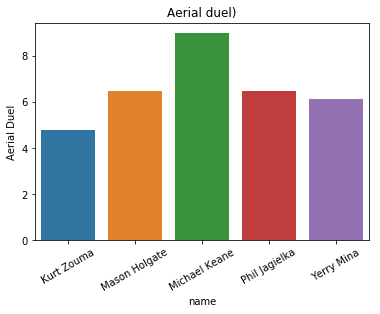

In [251]:
ax = sns.barplot(x ='name',y="Aerial Duel", data=df_edf)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title('Aerial duel)')
fig = ax.get_figure()
fig.savefig('Aerial duel.png')
            


##  Analysis - Part 3  : Game by game analysis of 5 players

In [252]:
#### Creating Profile for Michael Keane by each match
df_keane = df_keane.filter(cols_profile,axis=1)
df_kurt = df_kurt.filter(cols_profile,axis=1)
df_mina = df_mina.filter(cols_profile,axis=1)
df_holgate = df_holgate.filter(cols_profile,axis=1)
df_Jagielka = df_Jagielka.filter(cols_profile,axis=1)
df_koch= df_koch.filter(cols_profile,axis=1)   
df_light = df_light.filter(cols_profile,axis=1)  
 


cols = ['Pass Receiver Position_id','GK Shot Faced','Gk kick from hands','Keeper Throw']
#'Mins Played'
# dropping certain columns which are less-relevant to a Central defender
df_game_keane = df_keane.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1) 
df_game_kurt = df_kurt.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1) 
df_game_mina = df_mina.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1) 
df_game_holgate = df_holgate.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1)
df_game_Jagielka = df_Jagielka.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1) 
df_game_koch = df_koch.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1)
df_game_light = df_light.groupby(['Matchday'],as_index=False).sum().drop(cols,axis=1) 

In [253]:
#df_game_keane

In [254]:
# creating score for each player match by match
df_game_keane['score'] =df_game_keane['Defensive Duel']*10.0 + df_game_keane['Interception']*9.3 + df_game_keane['Successful Tackle']*10+df_game_keane['Aerial Duel']*8.7 + df_game_keane['Blocked Cross']*6.0 + df_game_keane['Blocked A Shot']*7.7+ df_game_keane['Tackle Attempt']*7.3+ df_game_keane['Ball Recovery']*7.7     
df_game_kurt['score'] =df_game_kurt['Defensive Duel']*10.0 + df_game_kurt['Interception']*9.3 + df_game_kurt['Successful Tackle']*10+df_game_kurt['Aerial Duel']*8.7 + df_game_kurt['Blocked Cross']*6.0 + df_game_kurt['Blocked A Shot']*7.7+ df_game_kurt['Tackle Attempt']*7.3+ df_game_kurt['Ball Recovery']*7.7     
df_game_mina['score'] =df_game_mina['Defensive Duel']*10.0 + df_game_mina['Interception']*9.3 + df_game_mina['Successful Tackle']*10+df_game_mina['Aerial Duel']*8.7 + df_game_mina['Blocked Cross']*6.0 + df_game_mina['Blocked A Shot']*7.7+ df_game_mina['Tackle Attempt']*7.3+ df_game_mina['Ball Recovery']*7.7     
df_game_holgate['score'] =df_game_holgate['Defensive Duel']*10.0 + df_game_holgate['Interception']*9.3 + df_game_holgate['Successful Tackle']*10+df_game_holgate['Aerial Duel']*8.7 + df_game_holgate['Blocked Cross']*6.0 + df_game_holgate['Blocked A Shot']*7.7+ df_game_holgate['Tackle Attempt']*7.3+ df_game_holgate['Ball Recovery']*7.7     
df_game_Jagielka['score'] =df_game_Jagielka['Defensive Duel']*10.0 + df_game_Jagielka['Interception']*9.3 + df_game_Jagielka['Successful Tackle']*10+df_game_Jagielka['Aerial Duel']*8.7 + df_game_Jagielka['Blocked Cross']*6.0 + df_game_Jagielka['Blocked A Shot']*7.7+ df_game_Jagielka['Tackle Attempt']*7.3+ df_game_Jagielka['Ball Recovery']*7.7     
df_game_koch['score'] =df_game_koch['Defensive Duel']*10.0 + df_game_koch['Interception']*9.3 + df_game_koch['Successful Tackle']*10+df_game_koch['Aerial Duel']*8.7 + df_game_koch['Blocked Cross']*6.0 + df_game_koch['Blocked A Shot']*7.7+ df_game_koch['Tackle Attempt']*7.3+ df_game_koch['Ball Recovery']*7.7     
df_game_light['score'] =df_game_light['Defensive Duel']*10.0 + df_game_light['Interception']*9.3 + df_game_light['Successful Tackle']*10+df_game_light['Aerial Duel']*8.7 + df_game_light['Blocked Cross']*6.0 + df_game_light['Blocked A Shot']*7.7+ df_game_light['Tackle Attempt']*7.3+ df_game_light['Ball Recovery']*7.7     



In [255]:
# craeying a game by game dataframe for each player
df_game_keane['name']='Michael Keane'
df_game_Jagielka['name'] = 'Phil Jagielka'
df_game_holgate['name'] = 'joseph holgate'
df_game_mina['name'] = 'Yerry Mina'
df_game_kurt['name'] = 'kurt zouma '
df_game_koch['name'] = 'Robin Koch'
df_game_light['name'] = 'matthijs de ligt '

In [256]:
# Concatening all of them to create a single dataframe
df_def_analysis = pd.concat([df_game_kurt,df_game_mina,df_game_holgate,df_game_Jagielka,df_game_keane,df_game_light,df_game_koch],axis=0)

#### Plotting match day by dat score of each of the player to see the progression

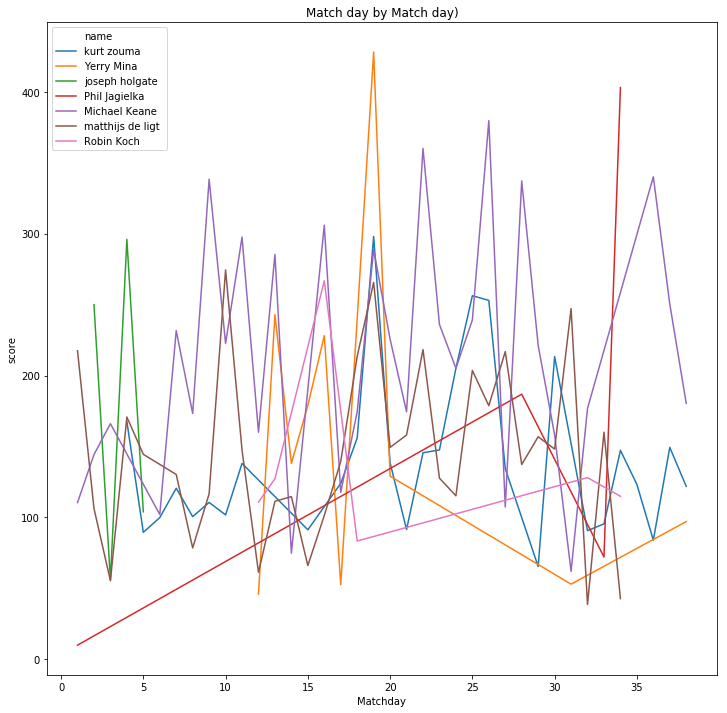

In [257]:
plt.figure(figsize=(12, 12))
ax = sns.lineplot(x="Matchday", y="score",data=df_def_analysis,hue="name")

#adding the title
plt.title('Match day by Match day)')
fig = ax.get_figure()

#saving the figure
fig.savefig('MATCH DAY.png')
            
 

# Home vs Away Performance

In [258]:
df.head()

,Game_id,Away Team Id,Away Team Name,Home Team Id,Home Team Name,Matchday,period_id,player_id,team_id,Position Id,Team,Opposition,Venue,Formation New,Formation Old,detailed_position,position_side,Team Goal Own Goal,Opposition Goal Own Goal,x,y,Pass End X,Pass End Y,Angle,Length,outcome,Key Pass,2nd Assist,Assist,Goal,Shot,Shot OP,Shot SP,Fast Break Shot,Big Chance,Long ball,Cross,Defensive Duel,Attacking Duel,Interception,Successful Tackle,Kick Off,Pull Back,Through Ball,Successful Take On,Out of Play,Corner,Open Play/Set Piece,Header,Received Pass,Received Pass X,Received Pass Y,Received Pass Player_id,Received Pass Player Surname,Pass Sender,Pass Receiver,Pass Receiver Team,min,sec,Possession_id,MatchName,Flank Pass,Subbed on?,Subbed off?,Throw in,Own Goal,Goal Kick,Possession Sequence,Possession Amount,Time,Time of Possession,Seconds Between,End of Possession,Possession End with Shot,First Time Pass,Shot 6 Secs After Cross,Player Full Name,Mins Played This Season,Red,Yellow,Blocked Shot,Switch of Play,Chipped Pass,Launched Pass,Layoff,Flick-on,Pass Receiver Position_id,Aerial Duel,GK Shot Faced,Subbed On Player,Subbed Off Player,Gk kick from hands,Keeper Throw,Shot from Corner,Shot from FK,Penalty,Header Shot,Mins Played,Blocked Cross,Blocked A Shot,Dispossessed/Tackled,Take On Attempt,Tackle Attempt,Ball Recovery,Lost Possession,xG OP,xA,name,pass type,Pass direction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018461996,987601,11,Everton,39,Wolverhampton Wanderers,1,1,80801,11,4,Everton,Wolverhampton Wanderers,Away,4231,4-2-3-1,Defensive Midfielder,Left/Centre,Everton,Wolverhampton Wanderers,65.129998,64.870002,47.19,61.88,183.34656,14.6,success,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Open Play,0,0,NaN,NaN,NaN,NaN,Gueye,Jagielka,Everton,0,0,2,Wolverhampton Wanderers v Everton,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,Idrissa Gueye,95,0,0,0,0,0,0,0,0,2.0,0,0,NaN,NaN,0,0,0,0,0,0,95,0,0,0,0,0,0,0,0.0,0.0,Idrissa Gueye,short,backward pass
1260708193,987601,11,Everton,39,Wolverhampton Wanderers,1,1,7645,11,2,Everton,Wolverhampton Wanderers,Away,4231,4-2-3-1,Central Defender,Centre/Right,Everton,Wolverhampton Wanderers,48.750000,59.929998,85.28,102.05,34.37748,36.8,Fail,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Open Play,0,1,36.3,47.6,80801.0,Gueye,Jagielka,Opposition,NaN,0,3,2,Wolverhampton Wanderers v Everton,0,0,0,0,0,0,2,2,3,3,3,0,0,0,0,Phil Jagielka,95,0,0,0,0,1,0,0,0,NaN,0,0,NaN,NaN,0,0,0,0,0,0,95,0,0,0,0,0,0,0,0.0,0.0,Phil Jagielka,short,Forward pass
1636741357,987601,11,Everton,39,Wolverhampton Wanderers,1,1,212319,11,4,Everton,Wolverhampton Wanderers,Away,4231,4-2-3-1,Wide Player,Left/Centre,Everton,Wolverhampton Wanderers,91.000000,103.220002,NaN,NaN,NaN,NaN,Fail,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Open Play,0,1,65.6,78.5,7645.0,Jagielka,NaN,Opposition,NaN,0,6,3,Wolverhampton Wanderers v Everton,0,0,0,0,0,0,1,3,6,0,3,0,0,0,0,Richarlison,86,0,0,0,0,0,0,0,0,NaN,1,0,NaN,NaN,0,0,0,0,0,0,86,0,0,0,0,0,0,0,0.0,0.0,Richarlison,Long,side ways
1500507604,987601,11,Everton,39,Wolverhampton Wanderers,1,1,106611,11,2,Everton,Wolverhampton Wanderers,Away,4231,4-2-3-1,Central Defender,Left/Centre,Everton,Wolverhampton Wanderers,66.820002,97.629998,80.21,92.04,343.77480,11.2,success,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Open Play,0,0,NaN,NaN,NaN,NaN,Keane,Richarlison,Everton,0,9,4,Wolverhampton Wanderers v Everton,0,0,0,0,0,0,1,2,9,0,2,0,0,0,0,Michael Keane,95,0,0,0,0,0,0,0,0,4.0,0,0,NaN,NaN,0,0,0,0,0,0,95,0,0,0,0,0,0,0,0.0,0.0,Michael Keane,short,Forward pass
1252704344,987601,11,Everton,39,Wolverhampton Wanderers,1,1,212319,11,4,Everton,Wolverhampton Wanderers,Away,4231,4-2-3-1,Wide Player,Left/Centre,Everton,Wolverhampton Wanderers,0.000000,0.000000,79.17,114.92,91.67328,10.3,success,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Open Play,0,0,NaN,NaN,NaN,NaN,NaN,Opposition,NaN,0,11,5,Wolverhampton Wanderers v Everton,0,0,0,0,0,0,1,1,11,0,0,0,0,0,0,Richarlison,86,0,0,

In [259]:
# Creating a home and away  dataframe
df_home = df[df['Home Team Name']=='Everton']

#away
df_away = df[df['Home Team Name']!='Everton']



#### Passing For Home

In [260]:
# Creating dataframes for pass profile for home
home_pass_plot = df_home.filter(cols_plot,axis=1).dropna()

# Creating dataframes for pass profile of Michael Keane for home
df_keane_plot_home =  home_pass_plot[home_pass_plot['name']=='Michael Keane']

#### Passing For Away

In [261]:
# Creating dataframes for pass profile for away
away_pass_plot = df_away.filter(cols_plot,axis=1).dropna()

# Creating dataframes for pass profile of Michael Keane for away
df_keane_plot_away =  away_pass_plot[away_pass_plot['name']=='Michael Keane']

In [262]:
df_keane_plot

,Game_id,Team,name,x,y,Pass End X,Pass End Y,Angle,Length,outcome,pass type,Pass direction
id,,,,,,,,,,,,
1500507604,987601,Everton,Michael Keane,66.820002,97.629998,80.21,92.04,343.77480,11.2,success,short,Forward pass
1600200234,987601,Everton,Michael Keane,45.110001,89.440004,45.24,62.14,269.29026,14.3,success,short,backward pass
1203792137,987601,Everton,Michael Keane,8.970000,92.429998,32.63,0.00,292.20858,52.9,Fail,Long,side ways
1667751464,987601,Everton,Michael Keane,9.230000,65.000000,24.57,66.95,5.72958,12.4,success,short,Forward pass
1698466078,987601,Everton,Michael Keane,14.040000,105.040004,3.38,63.70,246.37194,23.3,success,short,backward pass
1960846790,987601,Everton,Michael Keane,39.650000,57.850000,43.29,58.63,5.72958,3.0,Fail,short,Forward pass
2023595504,987601,Everton,Michael Keane,41.600000,85.020002,61.49,125.19,51.56622,26.4,success,short,side ways
2072065544,987601,Everton,Michael Keane,31.330000,98.800000,29.51,41.73,269.29026,29.9,success,short,backward pass
1411380591,987601,Everton,Michael Keane,18.200000,107.120002,7.93,71.76,246.37194,20.3,success,short,backward pass


#### 1(a) Plotting Passing in home 

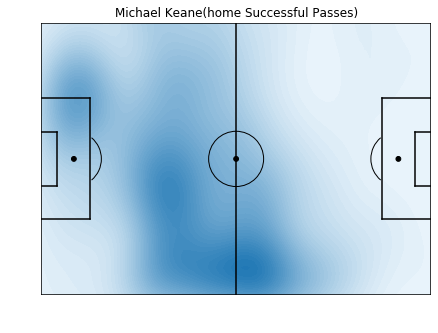

In [263]:
# Successful passing heatmap

draw_pitch()

#adding title
plt.title('Michael Keane(home Successful Passes)')

 
#sucess
keane_succes = df_keane_plot_home[df_keane_plot_home['outcome']=='success']
ax = sns.kdeplot(keane_succes['Pass End X'],keane_succes['Pass End Y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()



#### 1(b) Plotting Passing in away

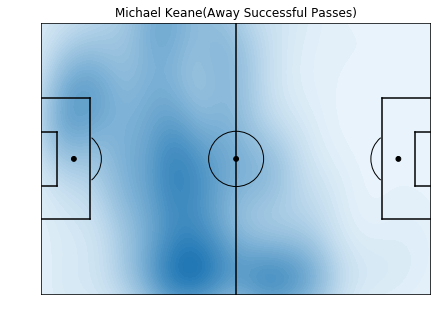

In [264]:
# Successful passing heatmap

draw_pitch()

#adding title
plt.title('Michael Keane(Away Successful Passes)')

 
#sucess
keane_succes = df_keane_plot_away[df_keane_plot_away['outcome']=='success']
ax = sns.kdeplot(keane_succes['Pass End X'],keane_succes['Pass End Y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

#### 2(a) Depth in home  

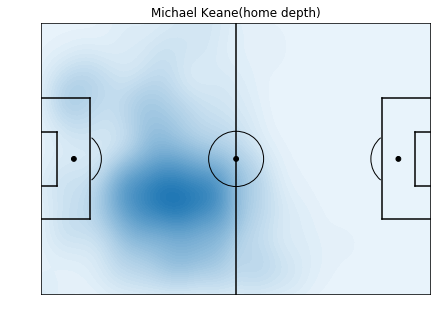

In [265]:
# Successful passing heatmap

draw_pitch()

#adding title
plt.title('Michael Keane(home depth)')

 
#sucess
ax = sns.kdeplot(df_keane_plot_home['x'],df_keane_plot_home['y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()


#### 2(a) Depth in away

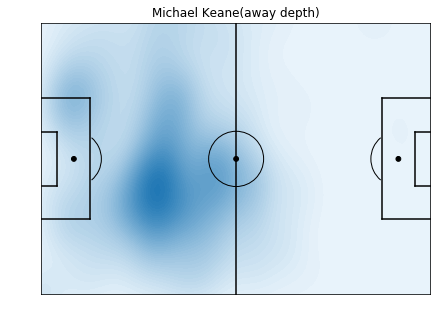

In [266]:
# Successful passing heatmap

draw_pitch()

#adding title
plt.title('Michael Keane(away depth)')

 
#sucess
ax = sns.kdeplot(df_keane_plot_away['x'],df_keane_plot_away['y'], shade=True,n_levels=50)


plt.ylim(0, 90)
plt.xlim(0, 130)


#Display Pitch
plt.show()

### Profiling for home and away for Michael Keane

1. Home

In [267]:
# Creating dataframes for profile for home
home_profile = df_home.filter(cols_profile,axis=1).dropna()

# Creating dataframes for profile of Michael Keane for home
df_keane_profile_home =  home_profile[home_profile['name']=='Michael Keane']

2. Away

In [268]:
# Creating dataframes of profile for away
away_profile = df_away.filter(cols_profile,axis=1).dropna()

# Creating dataframes of profile of Michael Keane for away
df_keane_profile_away =  away_profile[away_profile['name']=='Michael Keane']

In [269]:
df_keane_profile_away

,name,Matchday,Game_id,Pass Receiver Position_id,GK Shot Faced,Gk kick from hands,Keeper Throw,detailed_position,Mins Played,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery
id,,,,,,,,,,,,,,,,,
1500507604,Michael Keane,1,987601,4.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1600200234,Michael Keane,1,987601,2.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1698466078,Michael Keane,1,987601,1.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1960846790,Michael Keane,1,987601,4.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
2023595504,Michael Keane,1,987601,2.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
2072065544,Michael Keane,1,987601,2.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1411380591,Michael Keane,1,987601,1.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1959483850,Michael Keane,1,987601,4.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0
1382257966,Michael Keane,1,987601,4.0,0,0,0,Central Defender,95,0,0,0,0,0,0,0,0


In [270]:
df_keane_profile_away.groupby('name').sum()

,Matchday,Game_id,Pass Receiver Position_id,GK Shot Faced,Gk kick from hands,Keeper Throw,Mins Played,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery
name,,,,,,,,,,,,,,,
Michael Keane,13832,678610285,1970.0,0,0,0,65571,0,0,0,0,0,0,0,0


In [271]:
df_keane_profile_home.groupby('name').sum()

,Matchday,Game_id,Pass Receiver Position_id,GK Shot Faced,Gk kick from hands,Keeper Throw,Mins Played,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery
name,,,,,,,,,,,,,,,
Michael Keane,12336,624277804,1815.0,0,0,0,60475,0,0,0,0,0,0,0,0


In [272]:
df_keane_profile.groupby('name').sum()

,Matchday,Game_id,Pass Receiver Position_id,GK Shot Faced,Gk kick from hands,Keeper Throw,Mins Played,Defensive Duel,Interception,Successful Tackle,Aerial Duel,Blocked Cross,Blocked A Shot,Tackle Attempt,Ball Recovery
name,,,,,,,,,,,,,,,
Michael Keane,51901,2570218615,3785.0,0,0,0,248557,326,46,24,315,3,22,40,0
